In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from deepsky.data import load_storm_patch_data
from deepsky.gan import normalize_multivariate_data, stack_gen_disc, stack_enc_gen, train_gan_quiet, stack_gen_enc
from deepsky.models import LogisticGAN
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Input, UpSampling2D, MaxPool2D, BatchNormalization
from keras.layers import Activation, Reshape, LeakyReLU, concatenate, Dropout, GaussianNoise, AveragePooling2D
from keras.regularizers import l2
from keras.optimizers import Adam
import keras.backend as K
import xarray as xr


Using TensorFlow backend.


In [2]:
data_path = "/users/dgagne/ncar_ens_storm_patches/"


In [3]:
ds = xr.open_dataset("/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc")
ds

<xarray.Dataset>
Dimensions:                                                                                             (p: 152, x: 64, y: 64)
Coordinates:
    longitude                                                                                           (p, y, x) float32 ...
    latitude                                                                                            (p, y, x) float32 ...
  * p                                                                                                   (p) uint32 0 ...
  * y                                                                                                   (y) float32 0.0 ...
  * x                                                                                                   (x) float32 0.0 ...
Data variables:
    row                                                                                                 (p, y, x) int32 ...
    column                                                                        

In [3]:
variables = ["composite_reflectivity_entire_atmosphere_current"]
all_data, all_meta = load_storm_patch_data(data_path, variables, 2)

/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_20160

/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_07.nc 1265
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_08.nc 1270
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_09.nc 1185
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_10.nc 1470
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_01.nc 1020
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_02.nc 1140
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_03.nc 995
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_04.nc 825
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_05.nc 1025
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_06.nc 1110
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_07.nc 1000
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patc

/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_03.nc 2220
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_04.nc 2065
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_05.nc 2160
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_06.nc 2530
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_07.nc 2415
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_08.nc 2270
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_09.nc 1870
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_10.nc 2415
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052300_mem_01.nc 2445
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052300_mem_02.nc 3000
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052300_mem_03.nc 2375
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_pa

/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_09.nc 2395
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_01.nc 2000
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_10.nc 2805
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_02.nc 1850
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_03.nc 1955
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_04.nc 1840
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_05.nc 1780
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_06.nc 1520
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_07.nc 1990
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_08.nc 2110
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_09.nc 1850
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_pa

In [4]:
storm_norm_data, storm_scaling_values = normalize_multivariate_data(all_data)

In [5]:
output_data, output_meta = load_storm_patch_data(data_path,
                                                     ["thompson_max_hail_k1_surface_current",
                                                      "mask"], 4)
max_hail = np.array([output_data[i, :, :, 0][output_data[i, :, :, 1] > 0].max()
                         for i in range(output_data.shape[0])])
max_hail *= 1000
hail_labels = np.where(max_hail >= 25, 1, 0)

/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_20160

/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_06.nc 1260
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_08.nc 1270
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_10.nc 1470
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_01.nc 1020
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_09.nc 1185
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_02.nc 1140
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_04.nc 825
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_05.nc 1025
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_03.nc 995
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_06.nc 1110
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_07.nc 1000
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patc

/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_04.nc 2065
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_03.nc 2220
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_05.nc 2160
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_06.nc 2530
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_07.nc 2415
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_08.nc 2270
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_09.nc 1870
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_10.nc 2415
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052300_mem_02.nc 3000
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052300_mem_01.nc 2445
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052300_mem_03.nc 2375
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_pa

/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_01.nc 2000
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_09.nc 2395
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_02.nc 1850
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_10.nc 2805
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_03.nc 1955
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_04.nc 1840
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_05.nc 1780
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_06.nc 1520
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_07.nc 1990
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_08.nc 2110
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_09.nc 1850
/users/dgagne/ncar_ens_storm_patches/ncar_ens_storm_pa

In [15]:
def generator_model(input_size=100, filter_width=5, min_data_width=4,
                    min_conv_filters=64, output_size=(32, 32, 1), stride=2, activation="relu",
                    use_dropout=False, dropout_alpha=0,
                    use_noise=False, noise_sd=0.1):
    """
    Creates a generator convolutional neural network for a generative adversarial network set. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (int): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the first convolved layer after the input layer
        min_conv_filters (int): Number of convolutional filters in the last convolutional layer
        output_size (tuple of size 3): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.
        activation (str): Type of activation used for convolutional layers. Use "leaky" for Leaky ReLU.
        output_activation (str): Type of activation used on the output layer
        use_dropout (bool): Whether to use Dropout layers or not.
        dropout_alpha (float): proportion of nodes dropped out.
        use_noise: Whether to use a Gaussian noise layer after a convolution.
        noise_sd: Standard deviation of the Gaussian noise.

    Returns:
        Model output graph, model input
    """
    num_layers = int(np.log2(output_size[0]) - np.log2(min_data_width))
    max_conv_filters = int(min_conv_filters * 2 ** (num_layers))
    curr_conv_filters = max_conv_filters
    vector_input = Input(shape=(input_size, ), name="gen_input")
    model = Dense(units=max_conv_filters * min_data_width * min_data_width, 
                  kernel_regularizer=l2(0.001), use_bias=False)(vector_input)
    model = Reshape((min_data_width, min_data_width, max_conv_filters))(model)
    if activation == "leaky":
        model = LeakyReLU(alpha=0.1)(model)
    else:
        model = Activation(activation)(model)
    for i in range(num_layers):
        curr_conv_filters //= 2
        model = Conv2D(curr_conv_filters, (filter_width, filter_width),
                                strides=(stride, stride), padding="same", kernel_regularizer=l2(0.001))(model)
        if activation == "leaky":
            model = LeakyReLU(alpha=0.1)(model)
        else:
            model = Activation(activation)(model)
        if use_dropout:
            model = Dropout(dropout_alpha)(model)
        if use_noise:
            model = GaussianNoise(noise_sd)(model)
        if stride == 1:
            model = UpSampling2D()(model)

    model = Conv2D(curr_conv_filters, (filter_width, filter_width), 
                            padding="same", kernel_regularizer=l2(0.001))(model)
    if activation == "leaky":
        model = LeakyReLU(alpha=0.1)(model)
    else:
        model = Activation(activation)(model)    
    model = Conv2D(output_size[-1], (filter_width, filter_width),
                            strides=(1, 1),
                            padding="same", kernel_regularizer=l2(0.001))(model)
    model = BatchNormalization()(model)
    model_out = Model(vector_input, model)
    return model_out


def encoder_model(input_size=(32, 32, 1), filter_width=5, min_data_width=4,
                  min_conv_filters=64, output_size=100, stride=2, activation="relu", output_activation="linear",
                  use_dropout=False, dropout_alpha=0, use_noise=False, noise_sd=0.1, pooling="mean"):
    """
    Creates an encoder convolutional neural network that reproduces the generator input vector. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        output_size (int): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.
        activation (str): Type of activation used for convolutional layers. Use "leaky" for Leaky ReLU.
        output_activation (str): Type of activation used on the output layer
        use_dropout (bool): Whether to use Dropout layers or not.
        dropout_alpha (float): proportion of nodes dropped out.
        use_noise (bool): Whether to use a Gaussian noise layer after a convolution.
        noise_sd (float): Standard deviation of the Gaussian noise.
        pooling (str): Type of pooling to use if stride=1. Options: "mean" or "max".
    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    image_input = Input(shape=input_size, name="enc_input")
    model = None
    for c in range(num_layers):
        if c == 0:
            model = Conv2D(curr_conv_filters, (filter_width, filter_width),
                           strides=(stride, stride), padding="same", kernel_regularizer=l2(0.001))(image_input)
        else:
            model = Conv2D(curr_conv_filters, (filter_width, filter_width),
                           strides=(stride, stride), padding="same", kernel_regularizer=l2(0.001))(model)
        if activation == "leaky":
            model = LeakyReLU(0.2)(model)
        else:
            model = Activation(activation)(model)
        if use_dropout:
            model = Dropout(dropout_alpha)(model)
        if use_noise:
            model = GaussianNoise(noise_sd)(model)
        if stride == 1:
            if pooling.lower() == "mean":
                model = AveragePooling2D()(model)
            else:
                model = MaxPool2D()(model)
        curr_conv_filters *= 2
    model = Conv2D(curr_conv_filters, (filter_width, filter_width),
                       strides=(1, 1), padding="same", kernel_regularizer=l2(0.001))(model)
    model = Flatten()(model)
    model = Dense(output_size)(model)
    model = Activation(output_activation)(model)
    model = BatchNormalization()(model)
    model_out = Model(image_input, model)
    return model_out


def discriminator_model(input_size=(32, 32, 1), stride=2, filter_width=5,
                        min_conv_filters=64, min_data_width=4, activation="relu",
                        use_dropout=False, dropout_alpha=0, use_noise=False, noise_sd=0,
                        pooling="mean"):
    """
    Creates an discriminator convolutional neural network that reproduces the generator input vector.
    The keyword arguments allow aspects of the structure of the discriminator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        stride (int): Number of pixels that the convolution filter shifts between operations.
        activation (str): Type of activation used for convolutional layers. Use "leaky" for Leaky ReLU.
        use_dropout (bool): Whether to use Dropout layers or not.
        dropout_alpha (float): proportion of nodes dropped out.
        use_noise (bool): Whether to use a Gaussian noise layer after a convolution.
        noise_sd (float): Standard deviation of the Gaussian noise.
        pooling (str): Type of pooling to use if stride=1. Options: "mean" or "max".

    Returns:
        discriminator model output, encoder model output, image input
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    image_input = Input(shape=input_size, name="enc_input")
    model = image_input
    for c in range(num_layers):
        model = Conv2DTranspose(curr_conv_filters, (filter_width, filter_width),
                       strides=(stride, stride), padding="same", kernel_regularizer=l2(0.001))(model)
        if activation == "leaky":
            model = LeakyReLU(0.2)(model)
        else:
            model = Activation(activation)(model)
        if stride == 1:
            if pooling.lower() == "mean":
                model = AveragePooling2D()(model)
            else:
                model = MaxPool2D()(model)
        if use_dropout:
            model = Dropout(dropout_alpha)(model)
        if use_noise:
            model = GaussianNoise(noise_sd)(model)
        curr_conv_filters *= 2
    model = Conv2D(curr_conv_filters, (filter_width, filter_width),
                       strides=(1, 1), padding="same", kernel_regularizer=l2(0.001))(model)
    model = Flatten()(model)
    disc_model = Dense(1)(model)
    disc_model = Activation("sigmoid")(disc_model)
    model_out = Model(image_input, disc_model)
    return model_out

In [16]:
gen = generator_model(min_conv_filters=16, min_data_width=8, stride=1, 
                      activation="leaky", use_noise=True, noise_sd=0.01)
disc = discriminator_model(min_conv_filters=16, min_data_width=8, stride=1, 
                           activation="leaky", use_noise=True, noise_sd=0.01)
enc = encoder_model(min_conv_filters=16, min_data_width=8, stride=1, 
                    activation="leaky", use_noise=True, noise_sd=0.01)

In [17]:
opt = Adam(lr=0.0001, beta_1=0.5, beta_2=0.9, amsgrad=False)
gen.compile(optimizer=opt, loss="mse")
disc.compile(optimizer=opt, loss="binary_crossentropy")
enc.compile(optimizer=opt, loss="mse")

In [18]:
def stack_gen_disc(generator, discriminator):
    """
    Combines generator and discrminator layers together while freezing the weights of the discriminator layers.

    Args:
        generator (Keras Model object): Generator model
        discriminator (Keras Model object): Discriminator model

    Returns:
        Generator layers attached to discriminator layers.
    """
    discriminator.trainable = False
    model = discriminator(generator.output)
    model_obj = Model(generator.input, model)
    return model_obj


def stack_gen_enc(generator, encoder):
    """
    Combines generator and encoder layers together while freezing the weights of the generator layers.
    This is used to train the encoder network to convert image data into a low-dimensional vector
     representation.

    Args:
        generator: Decoder network
        encoder: Encoder network
    Returns:
        Encoder layers attached to generator layers
    """
    generator.trainable = False
    model = encoder(generator.output)
    model_obj = Model(generator.input, model)
    return model_obj

In [19]:
gen_disc = stack_gen_disc(gen, disc)
gen_disc.compile(optimizer=opt, loss="binary_crossentropy")
gen_enc = stack_gen_enc(gen, enc)
gen_enc.compile(optimizer=opt, loss="mse")

In [19]:
gen_disc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 64)          204864    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
gaussian_noise_7 (GaussianNo (None, 8, 8, 64)          0         
__________

In [20]:
disc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
gaussian_noise_9 (GaussianNo (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 64)        0         
__________

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [13]:
def train_gan_quiet(all_train_data, generator, discriminator, gen_disc, gen_enc, vec_size,
                    batch_size, num_epochs, gan_index):
    batch_size = int(batch_size)
    batch_half = int(batch_size // 2)
    batch_diff = all_train_data.shape[0] % batch_size
    if batch_diff > 0:
        train_data = all_train_data[:-batch_diff]
    else:
        train_data = all_train_data
    train_order = np.arange(train_data.shape[0])
    batch_labels = np.zeros(batch_size, dtype=np.float32)
    batch_labels[:batch_half] = 1
    gen_labels = np.ones(batch_size, dtype=np.float32)
    batch_vec = np.zeros((batch_size, vec_size))
    gen_batch_vec = np.zeros((batch_size, vec_size), dtype=train_data.dtype)
    enc_batch_vec = np.zeros((batch_size, vec_size), dtype=train_data.dtype)
    combo_data_batch = np.zeros(np.concatenate([[batch_size], train_data.shape[1:]]), dtype=np.float32)
    disc_loss_history = []
    gen_loss_history = []
    for epoch in range(1, num_epochs + 1):
        np.random.shuffle(train_order)
        for b, b_index in enumerate(np.arange(batch_half, train_data.shape[0] + batch_half, batch_half)):
            batch_vec[:] = np.random.normal(size=(batch_size, vec_size))
            gen_batch_vec[:] = np.random.normal(size=(batch_size, vec_size))
            combo_data_batch[:batch_half] = train_data[train_order[b_index - batch_half: b_index]]
            combo_data_batch[batch_half:] = generator.predict_on_batch(batch_vec[batch_half:])
            disc_loss_history.append(discriminator.train_on_batch(combo_data_batch, batch_labels))
            disc_preds = discriminator.predict_on_batch(combo_data_batch)
            gen_loss_history.append(gen_disc.train_on_batch(gen_batch_vec,
                                                            gen_labels))
            if b % 50 == 0:
                print("Combo: {0} Epoch: {1} Batch: {2} Disc: {3:0.3f} Gen: {4:0.3f}".format(gan_index,
                                                                                             epoch, b,
                                                                                             disc_loss_history[-1], 
                                                                                             gen_loss_history[-1]))
    
    gen_inputs = np.random.normal(size=(train_data.shape[0], vec_size))
    print("Fit Encoder Combo: {0}".format(gan_index))
    #gen_enc.fit(gen_inputs, gen_inputs, epochs=num_epochs, verbose=2)

In [20]:
train_gan_quiet(storm_norm_data, gen, disc, gen_disc, gen_enc, 100, 512, 4, 0)

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Combo: 0 Epoch: 1 Batch: 0 Disc: 0.763 Gen: 1.021
Combo: 0 Epoch: 1 Batch: 50 Disc: 0.729 Gen: 1.054
Combo: 0 Epoch: 1 Batch: 100 Disc: 0.698 Gen: 1.120
Combo: 0 Epoch: 1 Batch: 150 Disc: 0.803 Gen: 1.100
Combo: 0 Epoch: 1 Batch: 200 Disc: 0.886 Gen: 0.927
Combo: 0 Epoch: 1 Batch: 250 Disc: 0.711 Gen: 0.867
Combo: 0 Epoch: 1 Batch: 300 Disc: 0.704 Gen: 0.969
Combo: 0 Epoch: 1 Batch: 350 Disc: 0.713 Gen: 1.048
Combo: 0 Epoch: 1 Batch: 400 Disc: 0.738 Gen: 1.053
Combo: 0 Epoch: 2 Batch: 0 Disc: 0.741 Gen: 0.928
Combo: 0 Epoch: 2 Batch: 50 Disc: 0.636 Gen: 0.923
Combo: 0 Epoch: 2 Batch: 100 Disc: 0.584 Gen: 0.911
Combo: 0 Epoch: 2 Batch: 150 Disc: 0.695 Gen: 1.011
Combo: 0 Epoch: 2 Batch: 200 Disc: 0.601 Gen: 0.669
Combo: 0 Epoch: 2 Batch: 250 Disc: 0.754 Gen: 1.015
Combo: 0 Epoch: 2 Batch: 300 Disc: 0.800 Gen: 0.865
Combo: 0 Epoch: 2 Batch: 350 Disc: 0.703 Gen: 0.929
Combo: 0 Epoch: 2 Batch: 400 Disc: 0.730 Gen: 0.914
Combo: 0 Epoch: 3 Batch: 0 Disc: 0.720 Gen: 0.704
Combo: 0 Epoch: 3 Ba

In [21]:
random_codes = np.random.normal(size=(16, 100))
gen_samples = gen.predict(random_codes)
#enc_samples = enc.predict(gen_samples)

In [19]:
train_codes = enc.predict(storm_norm_data)

In [20]:
gen_train = gen.predict(train_codes)

In [61]:
train_neighbors = np.zeros(gen_samples.shape[0], dtype=int)
for i in range(enc_samples.shape[0]):
    train_neighbors[i] = np.argmin(np.sum((train_codes - enc_samples[i]) ** 2,axis=1))
    print(np.sum((train_codes - enc_samples[i]) ** 2,axis=1).min())

92.92037
86.100975
84.95398
97.78012
96.48079
73.970634
72.483246
68.28801
72.69274
68.585976
87.44389
86.50556
88.71172
75.91026
74.82147
90.2031


In [59]:
train_neighbors

array([59709, 48569,  3130, 30628, 11253, 41896, 24159, 48473, 92966,
       56212, 67397, 70130, 72186, 68141, 99144, 49933])

In [21]:
big_hail_cases = max_hail.argsort()[::-1][0:16]

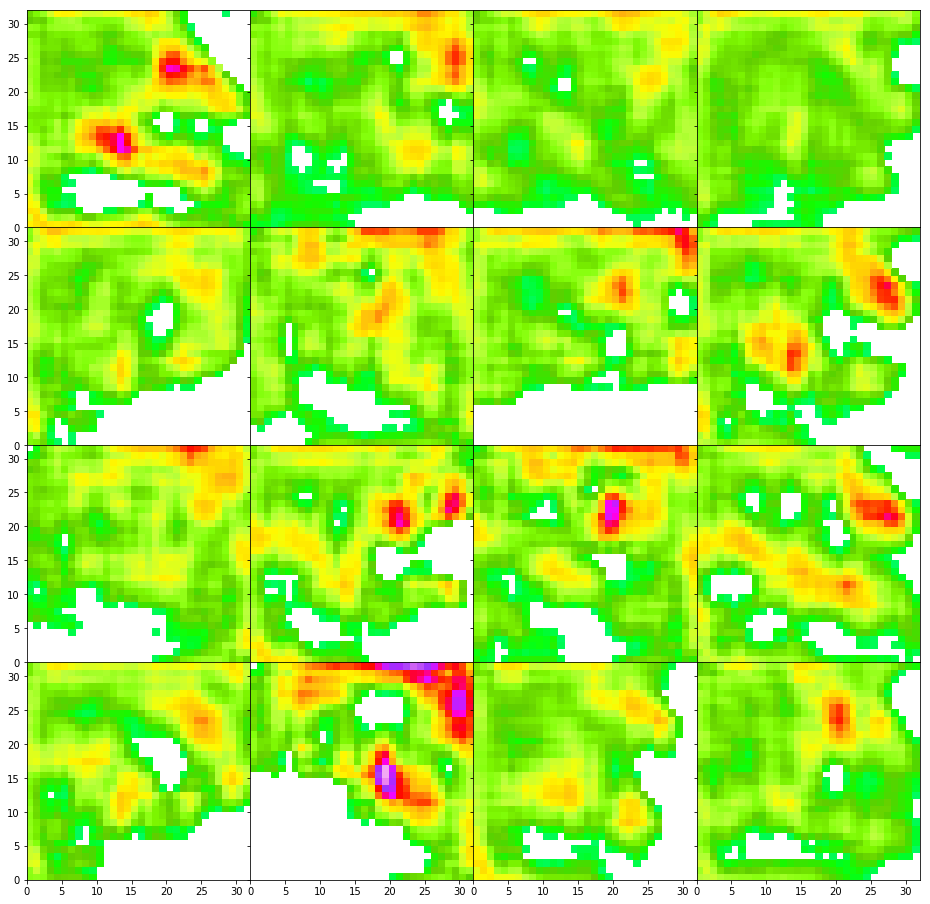

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
for a, ax in enumerate(axes.ravel()):
    scaled_sample = gen_samples[a, :, :, 0] * storm_scaling_values.iloc[0, 1] + storm_scaling_values.iloc[0, 0]
    pc = ax.pcolormesh(np.ma.array(scaled_sample, mask=scaled_sample <=10), 
                       vmin=-20, vmax=85, cmap="gist_ncar")
#plt.colorbar(pc)

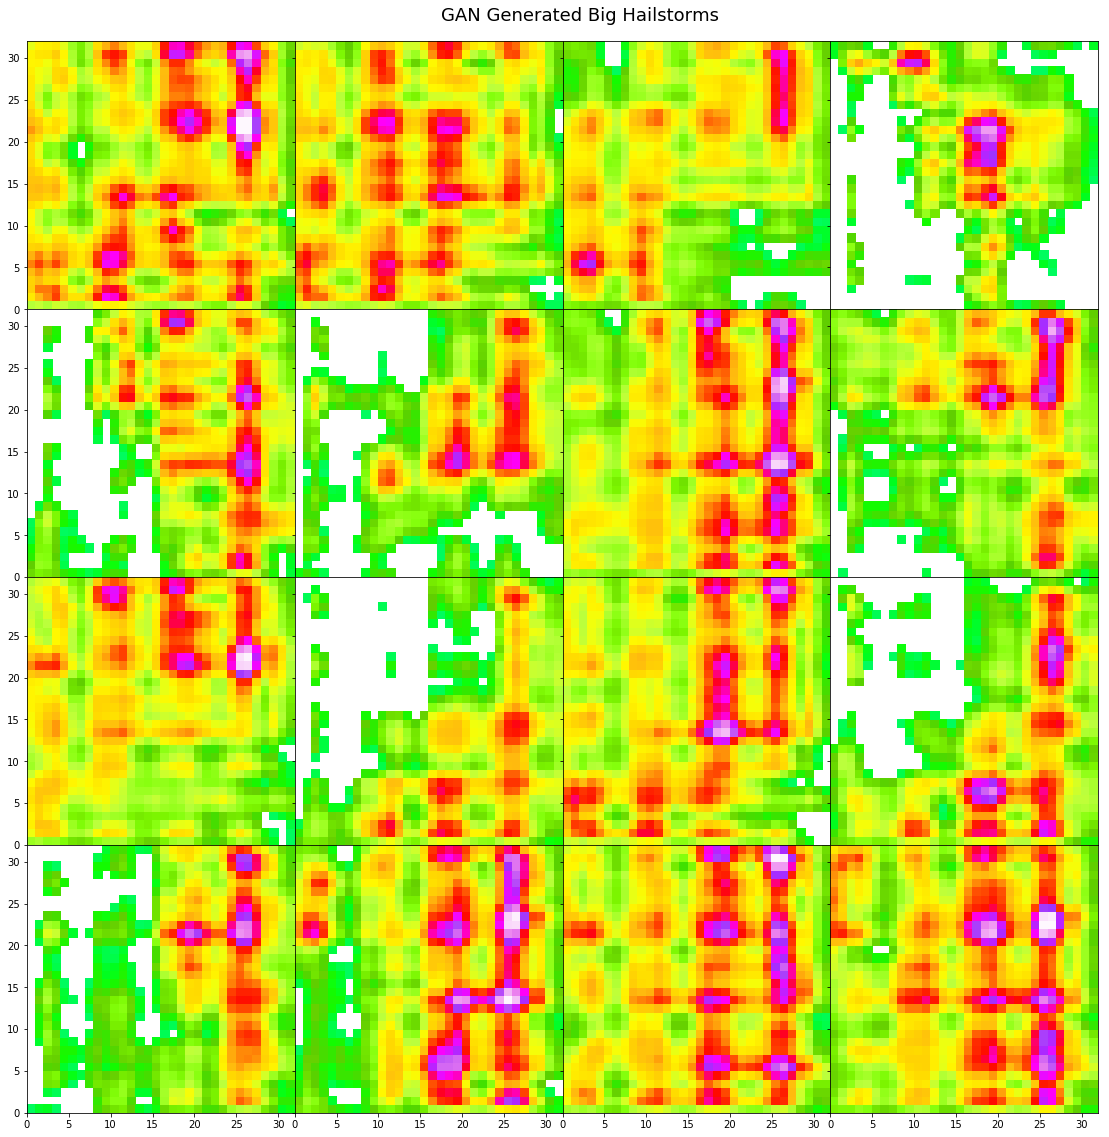

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
plt.subplots_adjust(0.02, 0.02, 0.95, 0.95, wspace=0, hspace=0)
for a, ax in enumerate(axes.ravel()):
    scaled_sample = gen_train[big_hail_cases[a], :, :, 0] * storm_scaling_values.iloc[0, 1] + storm_scaling_values.iloc[0, 0]
    pc = ax.pcolormesh(np.ma.array(scaled_sample, mask=scaled_sample <=10), 
                       vmin=-20, vmax=85, cmap="gist_ncar")
fig.suptitle("GAN Generated Big Hailstorms", fontsize=18)
plt.savefig("/users/dgagne/gan_generated_refl.png", dpi=300, bbox_inches="tight")

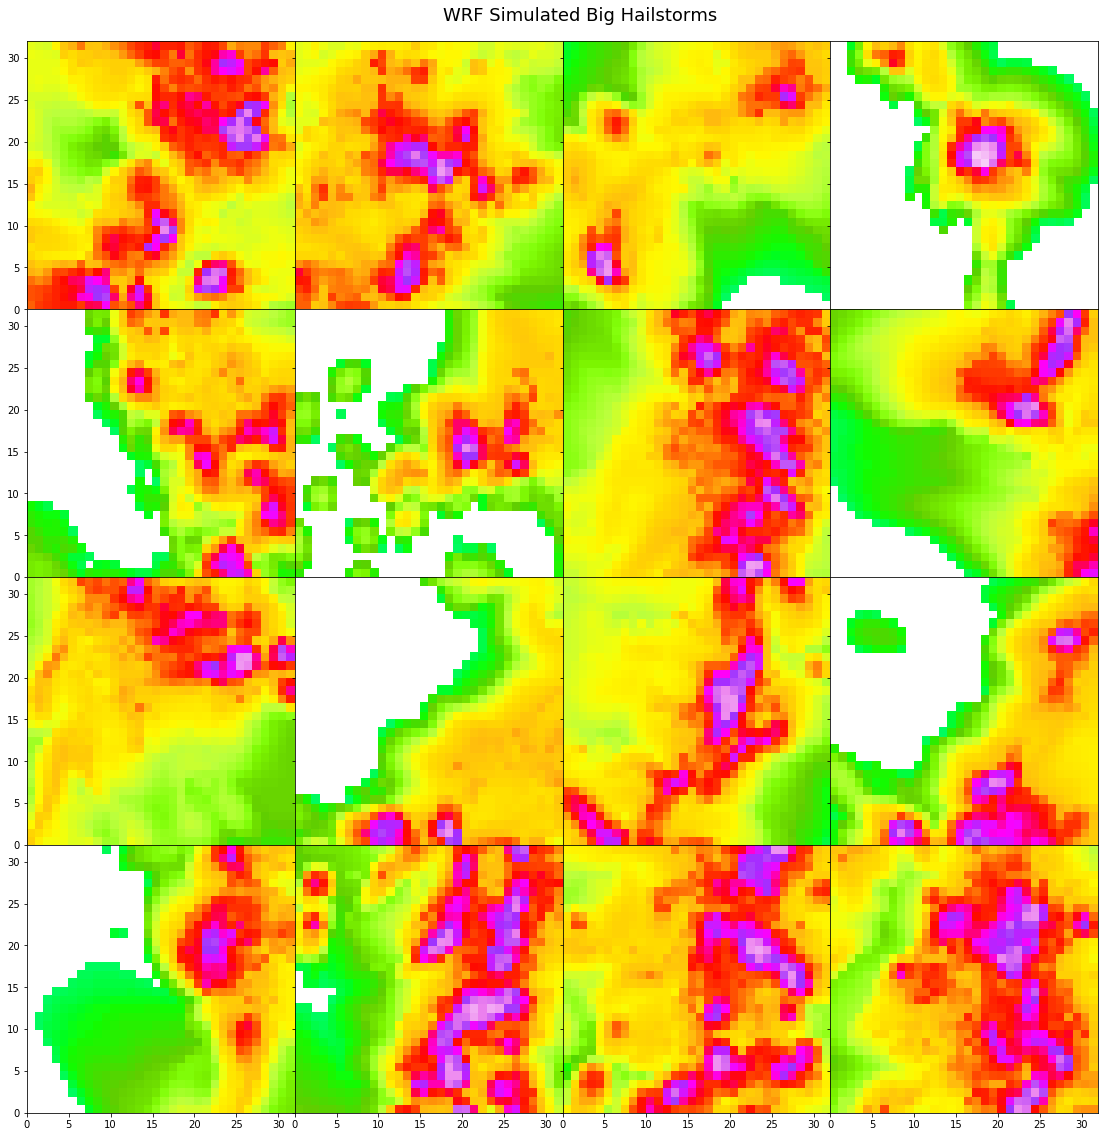

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
plt.subplots_adjust(0.02, 0.02, 0.95, 0.95, wspace=0, hspace=0)
for a, ax in enumerate(axes.ravel()):
    scaled_sample = storm_norm_data[big_hail_cases[a], :, :, 0] * storm_scaling_values.iloc[0, 1] + storm_scaling_values.iloc[0, 0]
    pc = ax.pcolormesh(np.ma.array(scaled_sample, mask=scaled_sample <=10), 
                       vmin=-20, vmax=85, cmap="gist_ncar")
fig.suptitle("WRF Simulated Big Hailstorms", fontsize=18)
plt.savefig("/users/dgagne/wrf_generated_refl.png", dpi=300, bbox_inches="tight")

In [178]:
gen_samples[a, :, :, 0].min()

-1.609933

array([59560, 67879, 67688, ..., 69451, 69453,     0])

In [18]:
gen_inputs = np.random.normal(size=(storm_norm_data.shape[0] // 3, 100))
print("Fit Encoder Combo: {0}".format(0))
gen_enc.fit(gen_inputs, gen_inputs, epochs=12, verbose=2)

Fit Encoder Combo: 0
Epoch 1/12
 - 25s - loss: 1.4529
Epoch 2/12
 - 23s - loss: 0.3639
Epoch 3/12
 - 23s - loss: 0.2172
Epoch 4/12
 - 23s - loss: 0.1776
Epoch 5/12
 - 23s - loss: 0.1582
Epoch 6/12
 - 23s - loss: 0.1459
Epoch 7/12
 - 23s - loss: 0.1373
Epoch 8/12
 - 23s - loss: 0.1307
Epoch 9/12
 - 23s - loss: 0.1256
Epoch 10/12
 - 23s - loss: 0.1214
Epoch 11/12
 - 23s - loss: 0.1179
Epoch 12/12
 - 23s - loss: 0.1148


In [47]:
gen_storm = gen.predict(enc.predict(storm_norm_data[0:1]))

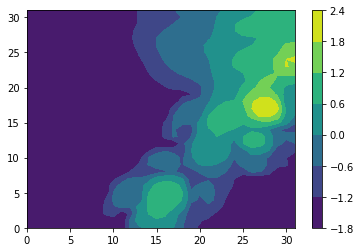

In [48]:
plt.contourf(storm_norm_data[0, :, :, 0])
plt.colorbar()

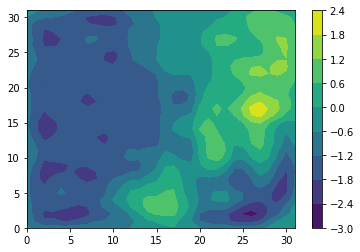

In [50]:
plt.contourf(gen_storm[0, :, :, 0])
plt.colorbar()

In [ ]:
gen_storm